# Machine Learning exercise

__Author__ = [Alexandre Combessie](mailto:alex@combessie.com)

__Date__ = June 27, 2016

## Introduction

The goal of this exercise is to demonstrate the skills required to run a simple Data Science workflow on real data. The dataset is provided beforehand : the classic "US Census", with training and test samples already selecting. The Machine Learning "task" is also well defined : predicting the income category (above/below USD 50 000) from a range of sociodemographic indicators. In scientific terms, it is a standard binary classification problem (supervised).  

In addition to pure Machine Learning performance, this exercise is about interpreting data and model outputs to provide insights understandable to all. Thus I have chosen to complete it as a *Jupyter notebook*, which allows to blend together Python code, text comments and data visualizations. The overall plan is derived from the standard data mining methodology **CRISP-DM**, which is described below.

<img src="crispdm.PNG">

## 1. Business understanding

**The question here is to understand what are the sociodemographic determinants of personal income.** Is it age? Sex? Race? Other characteristics? Or a combination of them? This problem is central to economists, sociologists and political decision-makers. Historically, a lot of effort in scientific research and public policy has been devoted to solving this problem. Generally speaking, the analysis of census data is a key reason behind the development of statistics and econometrics since the 1950s. In our case the question is relatively simple but census data can answer many others.

## 2. Environment loading and data acquisition

First I import necessary Python libraries, in particular `pandas` for data manipulation, `sklearn` for Machine Learning, and `matplotlib` for data visualization. Note that I also import my own module `CustomTransformers` which contains my own classes for data preparation.

In [1]:
# WARNING: part of the code below only works with Python 3 (parallelization)
import os
import zipfile
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle
import statsmodels
import weighted
import math
from CustomTransformers import ColumnExtractor, MultiColumnLabelEncoder, FillNaTransformer

Here we uncompress the source dataset.

In [2]:
zip_file_name = "us_census_full"
zfile = zipfile.ZipFile(zip_file_name+".zip")
zfile.extractall()

In [3]:
extracted_files = os.listdir("./"+zip_file_name)
print(extracted_files)

['census_income_learn.csv', 'census_income_metadata.txt', 'census_income_test.csv']


I manually created a text file containing the column names of the datasets. I had first tried extracting it automatically by parsing the `census_income_metadata.txt` file but the format was not consistent. Since there are only 42 columns, a manual extraction was a better option.

In [4]:
with open("col_names.txt", 'r') as f:
    col_names = f.read().splitlines() 

I also manually created a list matching each column to a type of variable (numerical or categorical) for easy conversion.

In [5]:
dtype_list=list(itertools.chain.from_iterable([[np.float64],["category"]*4, [np.float64],["category"]*10,[np.float64]*3, 
                                               ["category"]*5,[np.float64], ["category"]*5, [np.float64], ["category"]*8, 
                                               [np.float64], ["category"]*2]))
dict_type=dict(zip(col_names,dtype_list))

Here I read the files, convert them to `pandas` `DataFrame` and set the type of each column. Note that we had to specify the string used for missing values.

In [6]:
df={}
for f in extracted_files:
    if "csv" in f:
        df[f[:-4]]=pd.read_csv("./"+zip_file_name+"/"+f, na_values=[" ?","?"], names=col_names)
        for i in range(len(col_names)):
            df[f[:-4]][col_names[i]]=df[f[:-4]][col_names[i]].astype(dtype_list[i])

## 3. Data exploration and understanding

### a. Initial exploration

First let's display part of the dataset to see what it looks like. We can see that there are 199 523 lines in the training set to be compared to 99 762 in the test set (standard 70%/30% split). 

In [68]:
print(df["census_income_learn"].shape)
df["census_income_learn"].head()

(199523, 42)


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_veteran,veteran_benefits,weeks_worked_in_year,year,income_50000_binary
0,73.0,Not in universe,0,0,High school graduate,0.0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0.0,95,- 50000.
1,58.0,Self-employed-not incorporated,4,34,Some college but no degree,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52.0,94,- 50000.
2,18.0,Not in universe,0,0,10th grade,0.0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0.0,95,- 50000.
3,9.0,Not in universe,0,0,Children,0.0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,94,- 50000.
4,10.0,Not in universe,0,0,Children,0.0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,94,- 50000.


In [69]:
print(df["census_income_test"].shape)
df["census_income_test"].head()

(99762, 42)


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_veteran,veteran_benefits,weeks_worked_in_year,year,income_50000_binary
0,38.0,Private,6,36,1st 2nd 3rd or 4th grade,0.0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12.0,95,- 50000.
1,44.0,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0.0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26.0,95,- 50000.
2,2.0,Not in universe,0,0,Children,0.0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,95,- 50000.
3,35.0,Private,29,3,High school graduate,0.0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52.0,94,- 50000.
4,49.0,Private,4,34,High school graduate,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50.0,95,- 50000.


### b. Missing value analysis

*Nota Bene:* By missing values we do not include categorical responses with "Not in universe" but only "?" values

Overall most columns have no missing values, except those regarding migration and family origins (8 columns).

In [122]:
def percent_round(x,num=2):
    return(str(np.round(x*100,num))+"%")
print("Missing values per column in %:")
pd.DataFrame(
    df["census_income_test"].apply(lambda x:float(sum(x.isnull()))/len(x)).sort_values(ascending=False).apply(percent_round),
    columns=["Percent of missing values"])

Missing values per column in %:


,Percent of missing values
migration_prev_res_in_sunbelt,50.07%
migration_code_change_within_reg,50.07%
migration_code_change_in_msa,50.07%
migration_code_change_in_reg,50.07%
country_of_birth_father,3.44%
country_of_birth_mother,3.08%
country_of_birth_self,1.77%
state_of_previous_residence,0.33%
reason_for_unemployment,0.0%
member_of_labor_union,0.0%


### c. Univariate analysis

For this univariate analysis, we need to take care of a very important aspect of the dataset: each record represents a sample of the US population. As mentioned in the metadata explanatory file, the `instance_weight` column must be used on the distribution of other columns to derive real conclusions on the US population. For reference only, I have also included the univariate analysis without weighting.

#### Without weighting

Apparently there is no major problem with numeric outliers (common data mistakes such as unrealistic ages). At first glance data looks clean and in appropriate ranges.

In [70]:
numeric_description = df["census_income_learn"].describe(include=[np.float64])
numeric_description.loc[["mean","std","min","25%","50%","75%","max"],:].T.round(1)

,mean,std,min,25%,50%,75%,max
age,34.5,22.3,0.0,15.0,33.0,50.0,90.0
wage_per_hour,55.4,274.9,0.0,0.0,0.0,0.0,9999.0
capital_gains,434.7,4697.5,0.0,0.0,0.0,0.0,99999.0
capital_losses,37.3,271.9,0.0,0.0,0.0,0.0,4608.0
dividends_from_stocks,197.5,1984.2,0.0,0.0,0.0,0.0,99999.0
instance_weight,1740.4,993.8,37.9,1061.6,1618.3,2188.6,18656.3
num_persons_worked_for_employer,2.0,2.4,0.0,0.0,1.0,4.0,6.0
weeks_worked_in_year,23.2,24.4,0.0,0.0,8.0,52.0,52.0


The distribution of categorical variables is globally logical. However the top and frequency values do not reflect the reality of the US population since they have not been weighted.

In [71]:
categorical_description = df["census_income_learn"].describe(include=["category"])
categorical_description.loc["frequency",:]=(categorical_description.loc["freq",:]/categorical_description.loc["count",:])
categorical_description.loc[["unique","top","frequency"],:].T

,unique,top,frequency
class_of_worker,9,Not in universe,0.502423
industry_code,52,0,0.504624
occupation_code,47,0,0.504624
education,17,High school graduate,0.242614
enroll_in_edu_inst_last_wk,3,Not in universe,0.93695
marital_status,7,Never married,0.433459
major_industry_code,24,Not in universe or children,0.504624
major_occupation_code,15,Not in universe,0.504624
race,5,White,0.838826
hispanic_origin,10,All other,0.86159


#### With weighting (real analysis)

First let's study the distribution of numerical variables.

In [72]:
from statsmodels.stats.weightstats import DescrStatsW
numeric_col = [k for k,v in dict_type.items() if v!="category" and k!="instance_weight"]
weights_array = np.array(df["census_income_learn"].loc[:,"instance_weight"])
desc = DescrStatsW(df["census_income_learn"].loc[:,numeric_col], weights=weights_array)
Numeric_desc_weighted = pd.DataFrame(
    {"Mean":pd.Series(desc.mean), 
     "Std": pd.Series(desc.var).apply(lambda x: np.sqrt(x)),
     "Min": pd.Series(np.array(df["census_income_learn"].loc[:,numeric_col].apply(lambda x: min(x)))),
     "25%": pd.Series(np.array(df["census_income_learn"].loc[:,numeric_col].apply(
               lambda x: weighted.quantile(np.array(x), weights=weights_array, quantile=0.25)))),
     "50%": pd.Series(np.array(df["census_income_learn"].loc[:,numeric_col].apply(
               lambda x: weighted.quantile(np.array(x), weights=weights_array, quantile=0.5)))),
     "75%": pd.Series(np.array(df["census_income_learn"].loc[:,numeric_col].apply(
               lambda x: weighted.quantile(np.array(x), weights=weights_array, quantile=0.75)))),
     "Max": pd.Series(np.array(df["census_income_learn"].loc[:,numeric_col].apply(lambda x: max(x)))),
    }).round(1)
Numeric_desc_weighted.index = numeric_col
Numeric_desc_weighted.loc[:,["Mean","Std","Min","25%","50%","75%","Max"]]

,Mean,Std,Min,25%,50%,75%,Max
age,34.5,22.0,0.0,16.0,33.0,49.0,90.0
dividends_from_stocks,197.5,1937.8,0.0,0.0,0.0,0.0,99999.0
num_persons_worked_for_employer,2.0,2.4,0.0,0.0,1.0,4.0,6.0
capital_gains,441.6,4747.3,0.0,0.0,0.0,0.0,99999.0
wage_per_hour,57.4,281.0,0.0,0.0,0.0,0.0,9999.0
capital_losses,38.6,275.8,0.0,0.0,0.0,0.0,4608.0
weeks_worked_in_year,23.6,24.4,0.0,0.0,12.0,52.0,52.0


We can also do something more visual. This allows to highlight the skewed nature of dividends, capital gains/losses and wages. This highlights strong social inequalities within the US population (see Piketty et al.)

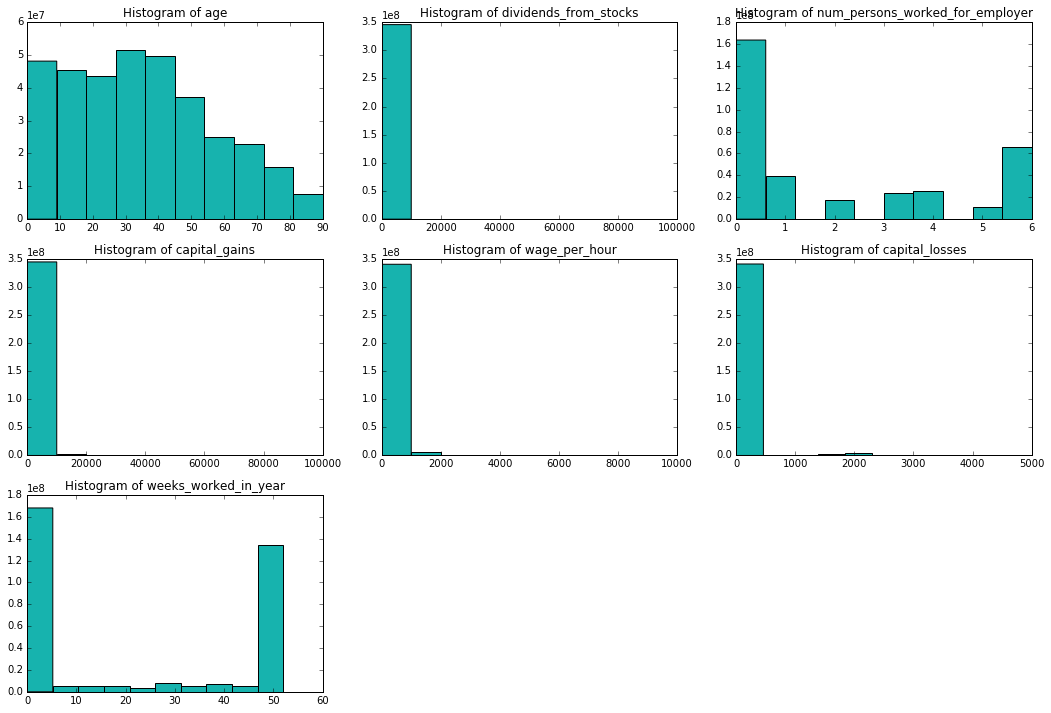

In [205]:
fig, axs = plt.subplots(int(math.ceil(len(numeric_col)/3.)),3,
                            figsize=(6*3,4*int(math.ceil(len(numeric_col)/3.))))
axs = axs.ravel()
for i in range(len(numeric_col)):
    axs[i].set_title("Histogram of "+numeric_col[i])
    axs[i].hist(df["census_income_learn"].loc[:,numeric_col[i]], weights=weights_array, color="#17B3AE")
for i in range(len(numeric_col),len(axs)):
    axs[i].axis("off")

Now let's see the distribution of categorical variables. It involves a bit of data wrangling in order to use instance weights. Note that we aggregate all categories below 5% in the same "Other" category.

In [51]:
category_col = [k for k,v in dict_type.items() if v=="category" and k!="instance_weight"]
df_train = df["census_income_learn"]
distrib_category_dic_weighted = {}
for c in category_col:
    labels = list(pd.Series(df_train.loc[:,c]).value_counts(dropna=False).index)
    weighted_sizes = [sum(df_train.loc[df_train.loc[:,c]==l,"instance_weight"]) for l in labels]
    labels_cleaned = [labels[i] for i,x in enumerate(weighted_sizes) if float(x)/sum(weighted_sizes)>=0.05]
    weighted_sizes_cleaned = [weighted_sizes[i] for i,x in enumerate(weighted_sizes) if float(x)/sum(weighted_sizes)>=0.05]
    if labels_cleaned is not None:
        labels_cleaned.append("Other")
        weighted_sizes_cleaned.append(sum([weighted_sizes[i] for i,x in enumerate(labels) if x not in labels_cleaned]))
    distrib_category_dic_weighted[c] = {
        "label": labels_cleaned,
        "size": weighted_sizes_cleaned,
    }

The code below automatically generates pie charts for all categorical variables. You can explore and interpret if as you wish, since it represents a realistic view of the real US population. One key insights from it is that the people earning more than USD 50 000 are a small minority of the population.

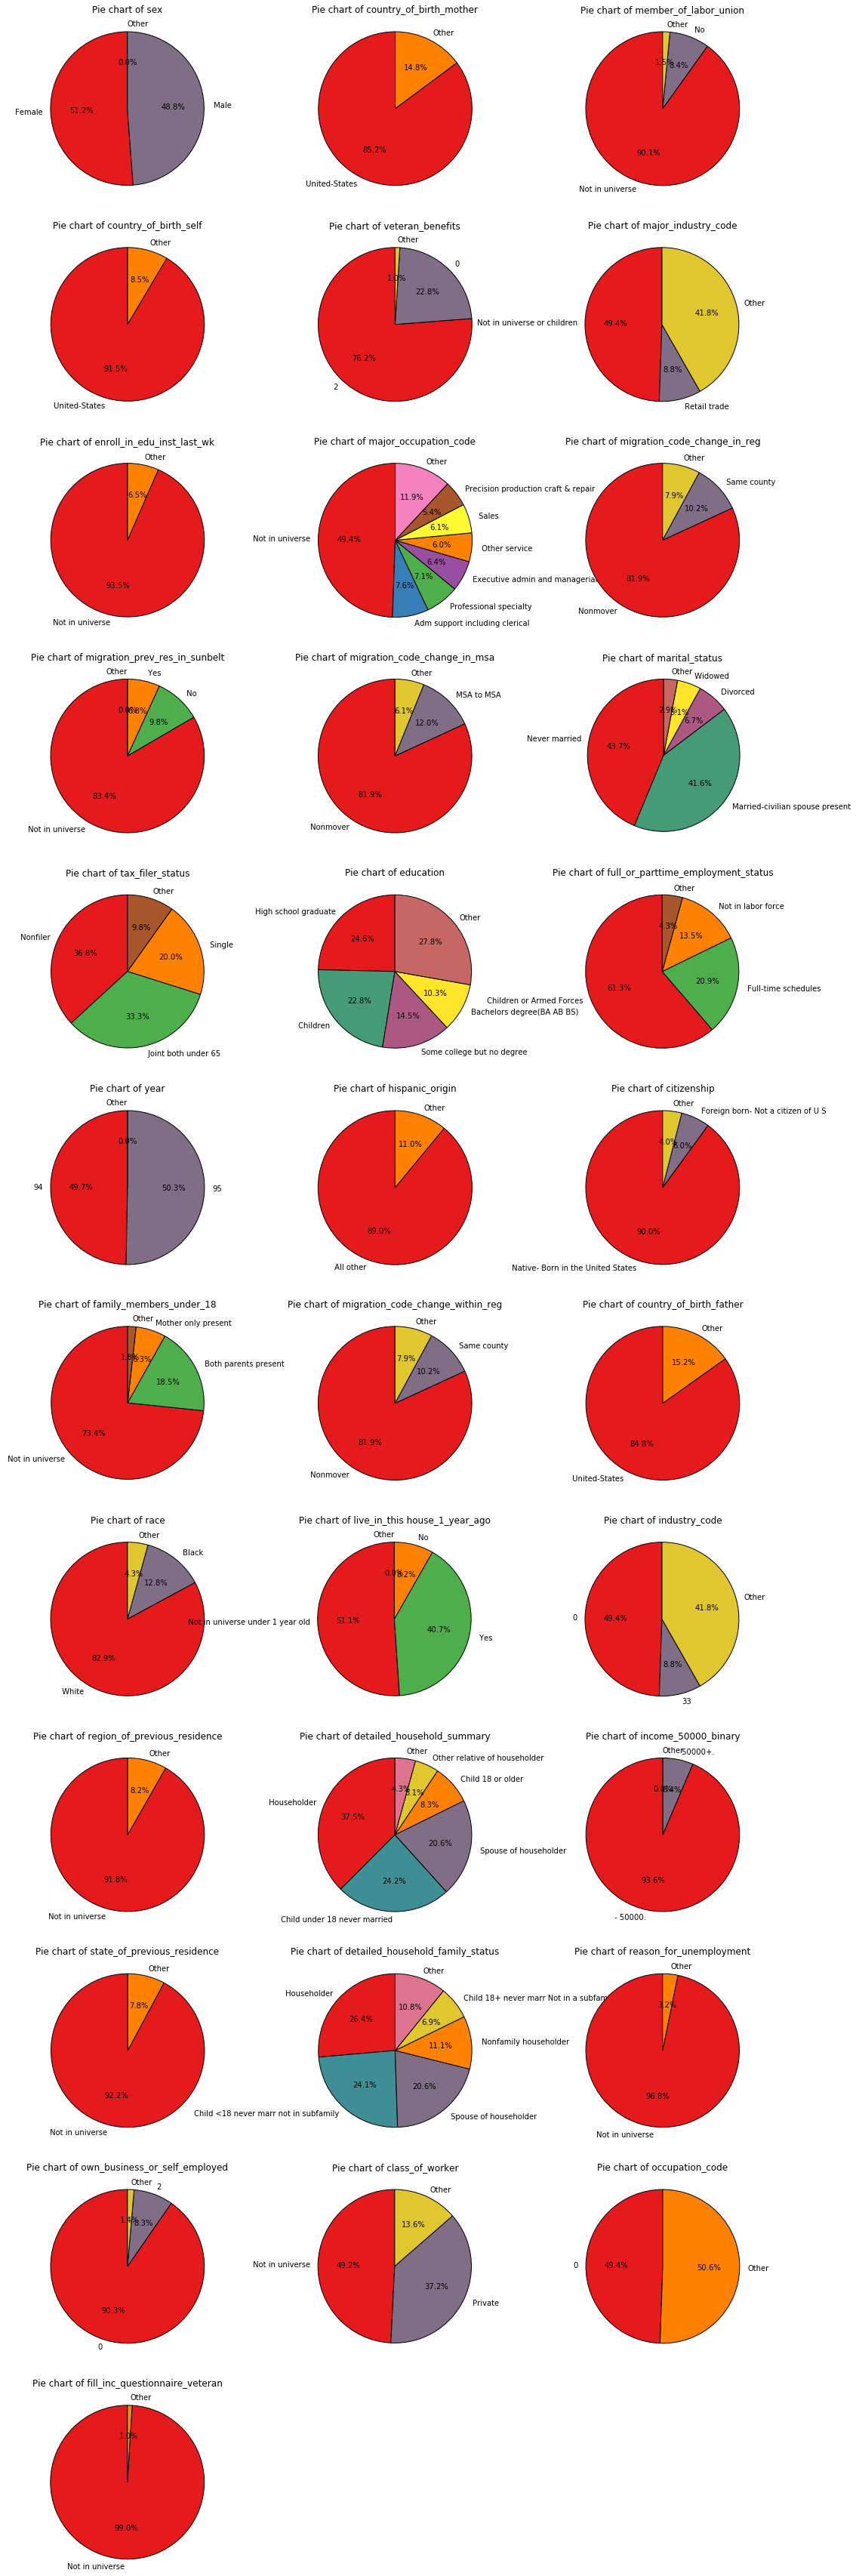

In [52]:
from matplotlib import cm
num_charts = len(distrib_category_dic_weighted.keys())
fig, axs = plt.subplots(int(math.ceil(num_charts/3.)),3,
                            figsize=(6*3,5*int(math.ceil(num_charts/3.))))
axs = axs.ravel()
plt.subplots_adjust(hspace=0.4)
for i in range(num_charts):
    col_name = list(distrib_category_dic_weighted.keys())[i]
    len_labels = len(distrib_category_dic_weighted[col_name]["label"])
    cs=cm.Set1(np.arange(len_labels)/float(len_labels))
    axs[i].set_title("Pie chart of "+col_name)
    axs[i].title.set_position([.5, 1.1])
    axs[i].pie(distrib_category_dic_weighted[col_name]["size"], 
                labels=distrib_category_dic_weighted[col_name]["label"], colors=cs,
        autopct='%1.1f%%',  startangle=90)
    axs[i].axis("equal")
for i in range(num_charts,len(axs)):
    axs[i].axis("off")

## 4. Data preparation

Here we select separately columns of numerical and categorical types. We take care to exclude the `instance_weight` columns as recommended in the metadata text file. 

In [7]:
category_col = [k for k,v in dict_type.items() if v=="category" and k!="instance_weight" and k!="income_50000_binary"]
numeric_col = [k for k,v in dict_type.items() if v!="category" and k!="instance_weight"]

In order to make our workflow efficient and avoid creating unnecessary Python objects, we wrap our entire data preparation job in a `sklearn Pipeline`, which is a great way to chain data transformers and models. Note that we use our custom transformer classes `ColumnExtractor` and `MultiColumnLabelEncoder`which do not exist in standard `sklearn`.

In [8]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(lambda x: x.replace(NaN))
pipe_prepa_X = Pipeline([
        ('features', FeatureUnion([
            ('numerical', Pipeline([
                ('extract', ColumnExtractor(numeric_col)),
                ('impute', sklearn.preprocessing.Imputer(strategy="mean")),
                ('scale', sklearn.preprocessing.StandardScaler()),
            ])),
            ('categorical', Pipeline([
                ('extract', ColumnExtractor(category_col)),
                ('missing_as_modality', FillNaTransformer()),
                ('labelencode', MultiColumnLabelEncoder()),
                ('onehot', sklearn.preprocessing.OneHotEncoder())
            ])),
        ]))
    ])

Once our `Pipeline` is created, we can apply it on our real datasets to define our training/test examples and labels. Note that we do not `fit` our `Pipeline` for the test set (standard methodology).

In [9]:
X_train = pipe_prepa_X.fit_transform(df["census_income_learn"])
X_test =  pipe_prepa_X.transform(df["census_income_test"])
y_train = df["census_income_learn"]["income_50000_binary"]
y_test = df["census_income_test"]["income_50000_binary"]

In [10]:
X_train.shape

(199523, 510)

Note that we have not included any dimensionality reduction method (Principal Component Analysis, etc.) in our `Pipeline`. After one-hot encoding categorical variables, there are only 510 columns in the feature matrix (for ~200k records), which is reasonable in our case.

## 5. Model creation

For this exercise we will implement 5 different models:
- Logistic regression
- Stochastic Gradient Descent
- Decision Tree
- Random Forest (ensemble method based on *aggregating* decision trees)
- AdaBoost (ensemble method based on *boosting* decision trees)

Finally, we will aggregate all these models through soft (probability) voting.

Many other models could also be tried such as Support Vector Machines or Neural Networks (Multi-layer perceptrons, etc.) but I have chosen standard models compatible with sparse matrix input and running in reasonable times. Another criterion was the ability for each model to predict probabilities, not only hard label assignment. For instance, it is computationally expensive for SVM models to provide these probabilities. The goal of having these probabilities is to facilitate the final voting aggregation model.

In [14]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression()
clf2 = SGDClassifier(loss="modified_huber")
clf3 = DecisionTreeClassifier()
clf4 = AdaBoostClassifier()
clf5 = RandomForestClassifier()
ensemble_clf = VotingClassifier(
    estimators=[('log', clf1), ('sgd', clf2), ('tree', clf3), ('ada', clf4), ('forest',clf5)], voting='soft')
clf_list=[clf1,clf2,clf3,clf4,clf5,ensemble_clf]
clf_name_list=['Logistic Regression','Stochastic Gradient Descent','Decision Tree',
               'AdaBoost','Random Forest','Ensemble Voting']
pos = u' 50000+.'

In order to choose the best model to apply to the test set, I run cross validation with a 5-fold strategy to compute several performance metrics:

**Accurary** = $\frac{TP}{Total}$ (simplest metric but sensitive to skewed classes which is our case)

**Precision** = $\frac{TP}{TP+FP}$ (ratio of correctly predicted positives among all positive predictions)

**Recall** = $\frac{TP}{TP+FN}$ (ratio of correctly predicted positives among all real positives)

**F1-score** = $\frac{2 \times Recall  \times Precision}{Recall+Precision}$ (harmonic mean of Precision and Recall)

**AUC** = Area under the Receiver Operating Characteristic (ROC) curve (see more information on https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)

I have chosen positives to be people earning more than USD 50 000.
$TP$ stands for True Positives, $FP$ for False Positives and $FN$ for False Negatives.

### Vanilla classifiers

In [33]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
summary_result = pd.DataFrame(
    [{
        "Accuracy": np.mean(cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5)),
        "AUC": np.mean(cross_val_score(clf, X_train, y_train==pos, scoring="roc_auc", cv=5)),
        "f1": np.mean(cross_val_score(clf, X_train, y_train, scoring=make_scorer(f1_score, pos_label=pos), cv=5)),
        "precision": np.mean(cross_val_score(clf, X_train, y_train, scoring=make_scorer(precision_score, pos_label=pos),cv=5)),
        "recall": np.mean(cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score, pos_label=pos), cv=5))
    }
    for  clf in clf_list], 
    index=clf_name_list)
summary_result

,AUC,Accuracy,f1,precision,recall
Logistic Regression,0.944469,0.952732,0.508410,0.716877,0.393878
Stochastic Gradient Descent,0.923889,0.942573,0.500392,0.610177,0.354378
Decision Tree,0.724256,0.934093,0.479774,0.470119,0.486674
AdaBoost,0.943639,0.953153,0.509767,0.727106,0.392584
Random Forest,0.891192,0.950697,0.463413,0.703996,0.350589
Ensemble Voting,0.941078,0.952061,0.510006,0.701622,0.393714


We can see in the table above that these "vanilla" classifiers perform relatively well. Accuracy is obviously very good since classes are skewed. However the AUC score, which is insensitive to class distribution, reaches 94%. Precision and Recall are not so great (respectively 71% and 39%) which results in a mediocre F1-score of 51%.

We see that the 2 best models are Logistic Regression and Ensemble Voting (very close). However, it would be helpful to tune model hyperparameters to see if we can improve the F1-score.

### Hyperparameter optimization

Now we can go "Kaggle"-style and perform hyperparameter optimization on all our models through `GridSearch`. Again, I use a cross-validation strategy with 5 folds. The metric I have chosen to optimize is the F1-score, which is only 51% before optimization. Note that this type of search is very computationally intensive since the entire parameter space needs to be explored (combinatorial complexity). I have enabled parallelization over CPUs to accelerate it. It is convenient that `sklearn` directly offers this option by using the library `joblib`. However, it only works on Python 3.

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
params={}
params["log"] = {'penalty': ['l1', 'l2'],
                 'class_weight': [None,'balanced']}
params["sgd"] = {'penalty': ['l1', 'l2', 'elasticnet'],
                 'class_weight': [None,'balanced']}
params["tree"] = {'criterion': ["gini","entropy"],
                  'class_weight': [None,'balanced']}
params["ada"] = {'n_estimators':[50,200],
                 'learning_rate':[0.1,1.0]}
params["forest"] = {'n_estimators':[50,200],
                    'class_weight': [None,'balanced']}
clf_dic = {'log': clf1, 'sgd': clf2, 'tree': clf3, 'ada': clf4, 'forest': clf5}
grid_dic = {k: GridSearchCV(estimator=v, param_grid=params[k], cv=5, scoring=make_scorer(f1_score, pos_label=pos), 
                            verbose=1, n_jobs=-1)
        for k, v in clf_dic.items()}

In [46]:
grid_dic_fitted = {k: v.fit(X_train,y_train) for k, v in grid_dic.items()}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.1min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 14.6min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 89.0min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 17.3min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.3s finished


Here are the best scores and paramaters for each classifier. Interestingly, it turns out that using balanced class weights does not improve the F1-score.

In [50]:
for k, v in grid_dic_fitted.items():
    print(k+": F1-score = "+ str(v.best_score_))
    print(v.best_params_ )

tree: F1-score = 0.482791390836
{'class_weight': None, 'criterion': 'entropy'}
ada: F1-score = 0.53527271242
{'learning_rate': 1.0, 'n_estimators': 200}
forest: F1-score = 0.510925750485
{'class_weight': None, 'n_estimators': 200}
log: F1-score = 0.508565984383
{'penalty': 'l2', 'class_weight': None}
sgd: F1-score = 0.472666080215
{'penalty': 'l1', 'class_weight': None}


Since this job was very long, I use the Python library `pickle` to save my models parameters to disk.

In [12]:
best_params_dic = {k: v.best_params_ for k,v in grid_dic_fitted.items()}
pickle.dump(best_params_dic, open("grid_dic_fitted"+".pickle","wb"))
best_params_dic = pickle.load(open("grid_dic_fitted"+".pickle","rb"))

Now we can apply our optimized models to see all the performance metrics

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
clf_dic_optimized = {k: clf_dic[k].set_params(**v) for k,v in best_params_dic.items()}
clf_dic_optimized["ensemble"] = VotingClassifier(estimators=[(k, v) for k,v in clf_dic_optimized.items()], voting='soft')
summary_result_optimized = pd.DataFrame(
    [{
        "Accuracy": np.mean(cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5, n_jobs=-1)),
        "AUC": np.mean(cross_val_score(clf, X_train, y_train==pos, scoring="roc_auc", cv=5, n_jobs=-1)),
        "f1": np.mean(cross_val_score(clf, X_train, y_train, scoring=make_scorer(f1_score, pos_label=pos), cv=5, n_jobs=-1)),
        "precision": np.mean(cross_val_score(clf, X_train, y_train, scoring=make_scorer(precision_score, pos_label=pos),
                                             cv=5, n_jobs=-1)),
        "recall": np.mean(cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score, pos_label=pos), 
                                          cv=5, n_jobs=-1)),
    }
    for  k,clf in clf_dic_optimized.items()], 
    index=["AdaBoost","Random Forest","Logistic Regression","Ensemble Voting","Decision Tree","Stochastic Gradient Descent"])

In [21]:
line_order = ["Logistic Regression","Stochastic Gradient Descent","Decision Tree","AdaBoost","Random Forest","Ensemble Voting"]
col_order = ["AUC","Accuracy","f1","precision","recall"]
summary_result_optimized.loc[line_order,col_order]

,AUC,Accuracy,f1,precision,recall
Logistic Regression,0.944467,0.952472,0.508541,0.717130,0.393959
Stochastic Gradient Descent,0.916786,0.940739,0.499214,0.514054,0.516622
Decision Tree,0.940094,0.953083,0.509298,0.740254,0.388547
AdaBoost,0.725254,0.934143,0.478879,0.476399,0.488370
Random Forest,0.948257,0.954176,0.535273,0.728524,0.423112
Ensemble Voting,0.944988,0.952366,0.532394,0.730938,0.419156


**The two best optimized classifiers are the Random Forest and the ensemble voting classifier.** If I had to choose only one to apply to the test set, I would probably choose the random forest for computational reasons. Note that the score reported here differ from the ones computed in the `GridSearch`: results are sensitive to the k-fold sampling.

*Side-note*: It would have been possible to perform the `GridSearch` directly on the final aggregation voting classifier. This approach would have been even more robust. However, it proved too long to run, even with parallelization. I estimate the theoretical time to 6 days with my computer configuration using 4 CPU cores. You can see the code below.

In [51]:
#from sklearn.grid_search import GridSearchCV
#params = {'log__penalty': ['l1', 'l2'],
#          'log__class_weight': [None,'balanced'],
#          'sgd__penalty': ['l1', 'l2', 'elasticnet'],
#          'sgd__class_weight': [None,'balanced'],
#          'tree__class_weight': [None,'balanced'],
#          'ada__n_estimators':[50,200],
#          'ada__learning_rate':[0.1,1.0],
#          'forest__n_estimators':[50,200],
#          'forest__class_weight': [None,'balanced'],
#          'weights':[[1,1,1,1,1], [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0],[0,0,0,1,0], [0,0,0,0,1]],
#         }
#grid = GridSearchCV(estimator=ensemble_clf, param_grid=params, cv=5, scoring=make_scorer(f1_score, pos_label=pos), n_jobs=4)

## 6. Evaluation

Now it is time to evaluate our optimized models on unseen data: the test set.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
clf_dic_optimized = {k: clf_dic[k].set_params(**v) for k,v in best_params_dic.items()}
clf_dic_optimized["ensemble"] = VotingClassifier(estimators=[(k, v) for k,v in clf_dic_optimized.items()], voting='soft')
clf_dic_optimized_fitted = {k: clf.fit(X_train,y_train) for  k,clf in clf_dic_optimized.items()}
pred_dic = {k: clf.predict(X_test) for k,clf in clf_dic_optimized_fitted.items()}

In [28]:
summary_result_test = pd.DataFrame(
    [{
        "Accuracy": accuracy_score(y_pred=pred_dic[k],y_true=y_test),
        "AUC": accuracy_score(y_pred=(pred_dic[k]==pos),y_true=(y_test==pos)),
        "f1": f1_score(y_pred=pred_dic[k],y_true=y_test,pos_label=pos),
        "precision": precision_score(y_pred=pred_dic[k],y_true=y_test,pos_label=pos),
        "recall": recall_score(y_pred=pred_dic[k],y_true=y_test,pos_label=pos),
    }
    for k,clf in clf_dic_optimized_fitted.items()], 
    index=["Decision Tree","AdaBoost","Ensemble Voting","Logistic Regression","Random Forest","Stochastic Gradient Descent"])
line_order = ["Logistic Regression","Stochastic Gradient Descent","Decision Tree","AdaBoost","Random Forest","Ensemble Voting"]
col_order = ["AUC","Accuracy","f1","precision","recall"]
summary_result_test.loc[line_order,col_order]

,AUC,Accuracy,f1,precision,recall
Logistic Regression,0.952978,0.952978,0.503335,0.729365,0.384255
Stochastic Gradient Descent,0.949309,0.949309,0.466392,0.671528,0.357258
Decision Tree,0.935747,0.935747,0.486378,0.482205,0.490624
AdaBoost,0.954802,0.954802,0.540320,0.731438,0.428387
Random Forest,0.953680,0.953680,0.479089,0.791434,0.343518
Ensemble Voting,0.954051,0.954051,0.532054,0.721884,0.421274


It turns out that the best model in terms of F1-score is AdaBoost, which was not our guess based on the training set. Ensemble voting is also very strong according to all metrics. It confirms the empirical fact that ensembling is the best way to improve predictive performance (cf. excellent post on http://mlwave.com/kaggle-ensembling-guide/). In terms of precision, Random Forest beats all other classifiers.

Finally it is easy to use our models to derive insights on what variables are important to predict income. Let's use the random forest model to do that on the training set. Note that I had to do an alternate method for data preparation in order to get feature names.

In [80]:
col_to_keep = [k for k,v in dict_type.items() if k!="income_50000_binary" and k!="instance_weight"]
X_train_dummy = pd.get_dummies(df["census_income_learn"].loc[:,col_to_keep], 
                               dummy_na=True, drop_first=True)

In [81]:
forest = clf_dic["forest"]
forest.fit(X_train_dummy, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

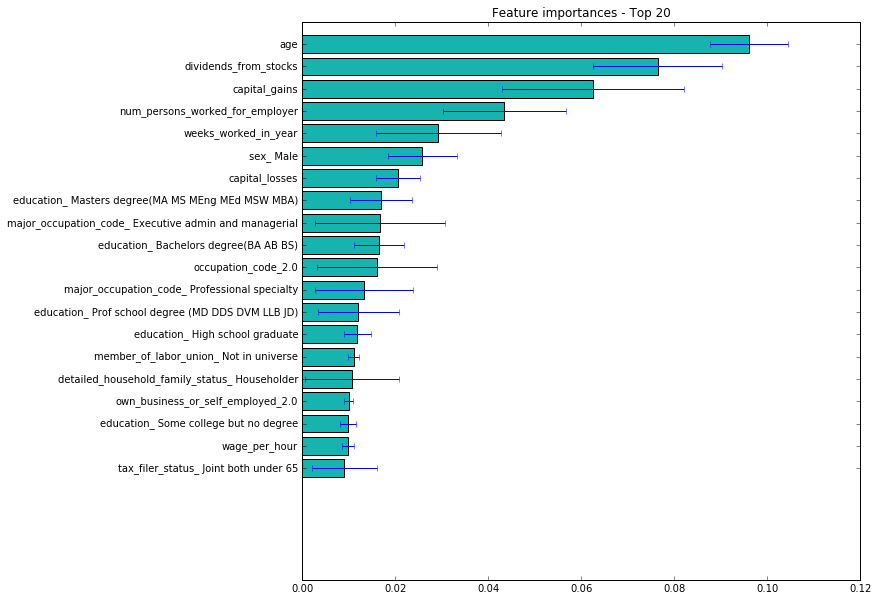

In [89]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
keep_top = 20
indices_top = indices[:keep_top]
plt.figure(figsize=(10,10))
plt.title("Feature importances - Top "+str(keep_top))
plt.barh(range(keep_top), importances[indices_top][::-1],
       color="#17B3AE", xerr=std[indices_top][::-1], align="center")
plt.yticks(range(keep_top), X_train_dummy.columns[indices_top][::-1])
plt.show()

**As we could expect, the first determinant of income is age. Then comes capital income: dividends and capital gains/losses. Gender, education and professional occupation also play a big role.**

## Conclusion

This exercise was interesting as it covers the entire standard Data Science workflow applied to a real dataset. It shows that it is relatively easy to predict income categories from sociodemographic characteristics. It was quite easy since there was only one small & relatively clean dataset. In real life data is difficult to access, messy, and much "bigger".  

It was also an opportunity for me to streamline this workflow efficiently by leveraging advanced `Pandas` and `sklearn` features. It made me realize that much of the work of a Data Scientist can be accelerated or automatized. In particular, common data preparation and data visualization tasks can be rather tedious, with little added value. 

I use Dataiku in my daily work as a Data Scientist and I really appreciate the productivity I gain thanks to this tool. It will always be important to create custom code and algorithms, but it helps to have a visual tool to manage its workflow, automate & optimize the "boring" time-consuming parts. I believe it is an amazing tool for that, as it allows Data Scientists to spend time on more important issues such as model improvements, data interpretation and business communication.